<a href="https://colab.research.google.com/github/nov05/Google-Colaboratory/blob/master/20250604_map_reduce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Notebook modified by nov05 on 2025-06-04  

In [ ]:
!pip install langchain_google_vertexai langchain_core langgraph
## Successfully installed httpx-sse-0.4.0 langchain_google_vertexai-2.0.24 langgraph-0.4.8 langgraph-checkpoint-2.0.26
## langgraph-prebuilt-0.2.2 langgraph-sdk-0.1.70 ormsgpack-1.10.0 pyarrow-19.0.1 validators-0.35.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 7.5 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.oauth2 import service_account
json_path = "/content/drive/MyDrive/config/20250604_google_service_account_key-lucid-bebop-461722-c5-a91d4ab1be75.json"
credentials = service_account.Credentials.from_service_account_file(json_path)
print(credentials)

# 🟢 **Handling a long input**  

Find a long video you'd like to process and put it on GCS:

In [ ]:
%%time
import os
from google.colab import userdata
import google.generativeai as genai

## watch the funny animation here
video_uri = "https://download.blender.org/peach/bigbuckbunny_movies/BigBuckBunny_320x180.mp4"
!wget {video_uri} -O video.mp4

# genai.configure(api_key=userdata.get('GOOGLE_API_KEY'))  ## ❌ works for GenAI only
# video_file_name = "video.mp4"
# print(f"Uploading file...")
# video_file = genai.upload_file(path=video_file_name)
# video_uri = video_file.uri
# print(f"Completed upload: {video_uri}")

--2025-06-05 05:16:04--  https://download.blender.org/peach/bigbuckbunny_movies/BigBuckBunny_320x180.mp4
Resolving download.blender.org (download.blender.org)... 172.67.14.163, 104.22.65.163, 104.22.64.163, ...
Connecting to download.blender.org (download.blender.org)|172.67.14.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64657027 (62M) [video/mp4]
Saving to: ‘video.mp4’

video.mp4           100%[===================>]  61.66M   129MB/s    in 0.5s    

2025-06-05 05:16:05 (129 MB/s) - ‘video.mp4’ saved [64657027/64657027]

Uploading file...
Completed upload: https://generativelanguage.googleapis.com/v1beta/files/1002rd0d7n58
CPU times: user 1.48 s, sys: 280 ms, total: 1.76 s
Wall time: 7.51 s


In [ ]:
from google.cloud import storage

project = "lucid-bebop-461722-c5"
bucket_name = "generative_ai_with_langchain"
blob_name = "video.mp4"
client = storage.Client(project=project, credentials=credentials)
bucket = client.bucket(bucket_name)
blob = bucket.blob(blob_name)
blob.upload_from_filename("video.mp4")
## (Optional) Make it public - ❌ This won't work for VertexAI respects crawling rules.
# blob.make_public()
# video_uri = blob.public_url
# Or use this URI if not public but accessible to Vertex AI
video_uri = f"gs://{bucket_name}/{blob_name}"  ## ✅
print("Video URI:", video_uri)

Video URI: gs://generative_ai_with_langchain/video.mp4


In [ ]:
%%time
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_google_vertexai import ChatVertexAI
from langchain_core.runnables import RunnableLambda

def _create_input_messages(*, video_uri:str, chunks:int=9, interval_secs:int=10):
    video_parts = []
    for start_offset in range(chunks):
        part = {
            "type": "media", "file_uri": video_uri, "mime_type": "video/mp4",
            "video_metadata": {
                "start_offset": {"seconds": start_offset*interval_secs},
                "end_offset": {"seconds": (start_offset+1)*interval_secs}}
        }
        video_parts.append(part)
    return [[HumanMessage(content=[human_part, vp])] for vp in video_parts]

human_part = {"type": "text", "text": "Provide a summary of the video."}
input_messages = _create_input_messages(video_uri=video_uri)
## https://cloud.google.com/vertex-ai/generative-ai/docs/models/gemini/2-0-flash
llm = ChatVertexAI(
    model="gemini-2.0-flash-001",
    project="lucid-bebop-461722-c5",  ## ✅ mandatory
    credentials=credentials           ## ✅ mandatory
)
map_chain = llm | StrOutputParser()
# summaries = map_chain.batch(input_messages, config={"max_concurrency": 3})
create_inputs_chain = RunnableLambda(lambda x: _create_input_messages(**x))
map_step_chain = create_inputs_chain | RunnableLambda(lambda x: map_chain.batch(x, config={"max_concurrency": 3}))
summaries = map_step_chain.invoke({"video_uri": video_uri})

CPU times: user 145 ms, sys: 36.5 ms, total: 181 ms
Wall time: 8.86 s


Let's define a function to merge summaries together:

In [ ]:
%%time
from langchain_core.prompts import PromptTemplate
from IPython.display import Markdown, display

def _merge_summaries(summaries:list[str], interval_secs:int=10, **kwargs) -> str:
    sub_summaries = []
    for i, summary in enumerate(summaries):
        sub_summary = (
            f"Summary from sec {i*interval_secs} to sec {(i+1)*interval_secs}:"
            f"\n{summary}\n")
        sub_summaries.append(sub_summary)
    return "".join(sub_summaries)

reduce_prompt = PromptTemplate.from_template(
    "You are given a list of summaries that "
    "of a video splitted into sequential pieces.\n"
    "SUMMARIES:\n{summaries}"
    "Based on that, prepare a summary of a whole video."
)
reduce_chain = RunnableLambda(lambda x: _merge_summaries(**x)) | reduce_prompt | llm | StrOutputParser()
final_summary = reduce_chain.invoke({"summaries": summaries})
display(Markdown(final_summary))

The video opens with serene animated landscapes, transitioning from a pink-skied field to a stream and a sleepy blue bird. At the 20-second mark, a cartoon bird falls from a tree, leading to the title card for "Big Buck Bunny." The scene then shifts to a forest clearing showing a bear sleeping in a cave in the base of the tree. A fat rabbit awakens in its burrow, stretches, and emerges into the sunny day. The rabbit explores a green field filled with flowers, enjoying the scenery. It sniffs white flowers, lies in the grass as a butterfly lands on its ear, and finally picks up an apple that falls from the sky, appearing thoughtful. The video appears to be an introduction to the animated short film, "Big Buck Bunny," showcasing the environment and introducing the main character.


CPU times: user 21.6 ms, sys: 2.82 ms, total: 24.4 ms
Wall time: 1.35 s


👉 Video summary example:  

**Google Cast: Evolution and Future - A Comprehensive Summary**  

This video, featuring Majd Bakar and John Affaki, explores the evolution of Google Cast and provides insights into its future direction.

**Introduction (0-600 seconds):**

The video begins by highlighting the success of Chromecast, a revolutionary $35 device that extends content from mobile devices to HDTVs. The Google Cast SDK and developer program, boasting over 6,000 developers, have been instrumental in expanding the casting ecosystem. The core vision for Google Cast revolves around: redefining interaction models with television (moving away from cumbersome experiences with technologies like gyroscopes and cameras), building a robust ecosystem, ensuring an open platform, and delivering a consistent user experience.  The ubiquity of mobile devices allows developers to focus on function without compromising form. The SDK is available for Android, iOS, and Web Apps in Chrome, and over 50% of Chromecast users utilize multiple platforms.  Key application areas include media streaming (video, music), and photo displays. This content can be served from the Cloud, a mobile device, or a local network. The architecture also supports multiple mobile devices connecting to a single session, enabling collaborative features like party modes, voting, and content sharing.

**New Features and Functionality (600-1200 seconds):**

The video showcases features like multi-player games (e.g., Big Web Quiz) and the Chromecast home screen displaying dynamic content.  The Chromecast home screen provides context-aware information to users interacting with their phones. John Affaki, leading the Google Cast SDK team, discusses upcoming features including:

*   **Cast to nearby devices:** Allowing casting without requiring devices to be on the same Wi-Fi network.
*   **Android TV integration:**  Bringing the same Google Cast functionality found in Chromecast to Android TV, enabling projection of Android apps onto the big screen without requiring extensive developer modifications.
*   **Media library improvements:** Including accessibility enhancements for the hearing impaired.

**Developer Focus and Future Directions (1200-1800 seconds):**

The video focuses on improvements for developers, including:

*   **Standardized Queuing API:**  Simplifying the creation, modification, and management of media item queues, replacing the need for individual apps to implement their own solutions.
*   **Full Featured Media Controls:**  Providing a consistent experience for interacting with media playback from any device.
*   **Secure Credential Transfer:**  Offering a secure method for transferring authentication credentials between sender and receiver for seamless service access within Google Cast. This is integrated with the queuing API, allowing for different credentials for different items in the queue.
*   **Improved App Discovery:**  Enhancing app discovery through a redesigned chromecast.com/apps website and an updated developer console for data gathering.
*   **Expanding Beyond Media:**  Exploring innovative applications beyond media and gaming and encouraging developers to provide feedback.

**Q&A: Addressing Developer Concerns (1800-3000 seconds):**

The video transitions to a Q&A session where developers raise various issues:

*   **Local Content Streaming:** Addressing how to stream local content to Chromecast by utilizing cloud-accessible URLs. Developers are advised to opt-out of local discovery in the development console.
*   **Audio/Video Latency:** Acknowledging the beta status of Android mirroring and efforts to minimize audio and video latency, especially for gaming.
*   **HMICEC Control:**  Clarifying that application control is not a platform limitation.
*   **Feature Timelines:**  While specific timelines are not provided, it is indicated that closed caption APIs are released, and screen casting/closed captioning within Google Play Services would be rolled out within a few weeks.
*   **"Screensaver" Integration:** Discussing how the presentation API in Android provides similar functionalities for seamless resumption, though not a full replacement for backdrop functionality.
*   **Cross-Domain Policies, Wi-Fi Security, and Android TV Hardware:** Addressing technical questions related to cross-domain policies, Wi-Fi security protocols, and hardware differences between Chromecast and Android TV. The lack of Google Play services on Amazon Kindle Fire is also mentioned.

**Conclusion:**

The video concludes with the presenters thanking the audience and announcing a Chromecast giveaway, highlighting Google's commitment to fostering a thriving Google Cast developer community. The overall message is that Google Cast is continuously evolving, with a focus on improving user experience, simplifying developer integration, and expanding beyond traditional media applications.  

Let's implement a reduce step that merges intermediatesummaries together:

In [ ]:
%%time
from langchain_core.runnables import RunnablePassthrough
## The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0.
## Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
# from langchain.chains import LLMChain
reduce_chain = (
    RunnableLambda(lambda x: _merge_summaries(**x)) |
    # LLMChain(llm=llm, prompt=reduce_prompt, output_parser=StrOutputParser())
    reduce_prompt | llm | StrOutputParser()
)
final_chain = (
    RunnablePassthrough.assign(summaries=map_step_chain).assign(final_summary=reduce_chain) |
    RunnableLambda(lambda x: x["final_summary"])
)
result = final_chain.invoke({"video_uri": video_uri, "interval_secs": 60, "chunks": 9})  ## almost full length
result

CPU times: user 146 ms, sys: 29 ms, total: 175 ms
Wall time: 14 s


'"Big Buck Bunny" is an animated short film that follows a large, gentle rabbit\'s experiences in a forest meadow. Initially, he enjoys the peaceful surroundings, but his tranquility is disrupted by a group of mischievous rodents – squirrels and a chinchilla. They steal from him and throw things at him, leading to comical revenge plots.\n\nThe rabbit attempts to trap the squirrels using various tools and contraptions, leading to slapstick scenarios involving bombs, booby traps, and chases through the forest. The conflict escalates with squirrels becoming victims of the rabbit\'s traps. The video culminates with one of the squirrels flying through the air with a kite string, held by the rabbit. The film then transitions to the credits, featuring animated squirrels and rodents in the background. The story blends humor and mild violence in a lighthearted animated style.\n'

In [ ]:
display(Markdown(result))

"Big Buck Bunny" is an animated short film that follows a large, gentle rabbit's experiences in a forest meadow. Initially, he enjoys the peaceful surroundings, but his tranquility is disrupted by a group of mischievous rodents – squirrels and a chinchilla. They steal from him and throw things at him, leading to comical revenge plots.

The rabbit attempts to trap the squirrels using various tools and contraptions, leading to slapstick scenarios involving bombs, booby traps, and chases through the forest. The conflict escalates with squirrels becoming victims of the rabbit's traps. The video culminates with one of the squirrels flying through the air with a kite string, held by the rabbit. The film then transitions to the credits, featuring animated squirrels and rodents in the background. The story blends humor and mild violence in a lighthearted animated style.


## Using LangGraph

Let's implement the same logic using LangGraph:

In [ ]:
import operator
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.constants import Send
from langgraph.graph import StateGraph, START, END


class AgentState(TypedDict):
    video_uri: str
    chunks: int
    interval_secs: int
    summaries: Annotated[list, operator.add]
    final_summary: str

class _ChunkState(TypedDict):
    video_uri: str
    start_offset: int
    interval_secs: int


human_part = {"type": "text", "text": "Provide a summary of the video."}

async def _summarize_video_chunk(state:  _ChunkState):
    start_offset = state["start_offset"]
    interval_secs = state["interval_secs"]
    video_part = {
        "type": "media", "file_uri": state["video_uri"], "mime_type": "video/mp4",
        "video_metadata": {
            "start_offset": {"seconds": start_offset*interval_secs},
            "end_offset": {"seconds": (start_offset+1)*interval_secs}}
    }
    response = await llm.ainvoke(
        [HumanMessage(content=[human_part, video_part])])
    return {"summaries": [response.content]}

def _map_summaries(state: AgentState):
    chunks = state["chunks"]
    payloads = [
        {
            "video_uri": state["video_uri"],
            "interval_secs": state["interval_secs"],
            "start_offset": i
        } for i in range(state["chunks"])
    ]
    return [Send("summarize_video_chunk", payload) for payload in payloads]

async def _generate_final_summary(state: AgentState):
    summary = _merge_summaries(
        summaries=state["summaries"], interval_secs=state["interval_secs"])
    final_summary = await (reduce_prompt | llm | StrOutputParser()).ainvoke({"summaries": summary})
    return {"final_summary": final_summary}

graph = StateGraph(AgentState)
graph.add_node("summarize_video_chunk", _summarize_video_chunk)
graph.add_node("generate_final_summary", _generate_final_summary)

graph.add_conditional_edges(START, _map_summaries, ["summarize_video_chunk"])
graph.add_edge("summarize_video_chunk", "generate_final_summary")
graph.add_edge("generate_final_summary", END)

app = graph.compile()

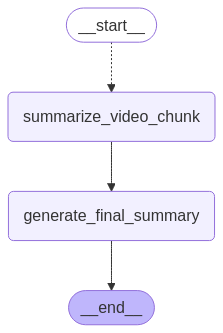

In [ ]:
from IPython.display import Image
Image(app.get_graph().draw_mermaid_png())

In [ ]:
result = await app.ainvoke(
    {"video_uri": video_uri, "chunks": 5, "interval_secs": 600},
    {"max_concurrency": 3}
)
print(result["final_summary"])

Okay, here's a comprehensive summary of the entire video, synthesized from the individual section summaries:

**Overall Video Summary:**

The video features Google Engineers Majid Abakar and John Afaki discussing the evolution of Google Cast and its future direction. They highlight Google Cast's goals: redefining TV interaction, offering compelling large-screen experiences, building an open and consistent ecosystem for both users and developers.

The presentation covers several key areas:

*   **Introduction to Google Cast:** It started with Chromecast for $35 and now encompasses a broader vision of bringing content to the largest screen possible using mobile devices as controllers.
*   **Interaction Model:** Focuses on seamless content consumption on large screens, leveraging mobile device portability. The user can use the cloud, their mobile device or the local cloud on other devices. With the ability to connect multiple mobile devices to a single session, this media app can bring gr

👉 Final summanry example:  

Okay, here's a comprehensive summary of the entire video, synthesized from the individual section summaries:

**Overall Video Summary:**

The video features Google Engineers Majid Abakar and John Afaki discussing the evolution of Google Cast and its future direction. They highlight Google Cast's goals: redefining TV interaction, offering compelling large-screen experiences, building an open and consistent ecosystem for both users and developers.

The presentation covers several key areas:

*   **Introduction to Google Cast:** It started with Chromecast for $35 and now encompasses a broader vision of bringing content to the largest screen possible using mobile devices as controllers.
*   **Interaction Model:** Focuses on seamless content consumption on large screens, leveraging mobile device portability. The user can use the cloud, their mobile device or the local cloud on other devices. With the ability to connect multiple mobile devices to a single session, this media app can bring great use cases such as party mode, voting and sharing content.
*   **Developer Focus:** Emphasizes ease of development using HTML5 and JavaScript, with UX guidelines for consistent user experiences.
*   **New Features and Updates:**
    *   Casting to nearby devices without Wi-Fi using location and ultrasound.
    *   Android TV integration with Cast functionalities.
    *   Updated Google Cast SDK supporting Smooth Stream, Dash, and HLS.
    *   Enhanced Closed Captioning support.
    *   Unified queue management API with functions for insert, remove, and reorder.
    *   Media controls on mobile devices for interacting with playing media even without the app.
    *   Improved app discovery through a redesigned Chromecast.com/apps website and a new developer console.
*   **Beyond Media:** Explores uses beyond media, including games, education, and business applications like presentations and digital signage.
*   **Q&A Session:**
    *   Discusses streaming local vs. foreign content.
    *   Addresses user opt-out of local discovery.
    *   Mentions casting from a desktop (experimental feature).
    *   Discusses primitives for images and slideshows.
    *   Explores the possibility of playing music and streaming photos simultaneously on Android TV (currently not planned).
    *   Addresses audio and video latency with Android mirroring (goal of low latency).
    *   Covers the option for individual applications to disable video display on the big screen (system function controlled at the level of protection).
    *   Confirms Cross Domain Auth is not going away.
    *   Mentions considerations for 5 GHz support (cannot discuss future hardware).
    *   States codec support will be identical on Chromecast and Android TV.
    *   Addresses Kindle Fire compatibility (SDK not available due to Google Play Services dependency).

The video concludes with the announcement of free Chromecasts being given away. In essence, the video provides an overview of Google Cast's current state, future enhancements, and its expanding role in various application areas.


In [ ]:
async for step in app.astream(
    {"video_uri": video_uri, "chunks": 5, "interval_secs": 600},
    {"recursion_limit": 10},
):
    print(list(step.keys()))

['summarize_video_chunk']
['summarize_video_chunk']
['summarize_video_chunk']
['summarize_video_chunk']
['summarize_video_chunk']
['generate_final_summary']


Let's look at the final summary:

In [ ]:
result["final_summary"]

"Okay, here's a comprehensive summary of the entire video, synthesized from the individual section summaries:\n\n**Overall Video Summary:**\n\nThe video features Google Engineers Majid Abakar and John Afaki discussing the evolution of Google Cast and its future direction. They highlight Google Cast's goals: redefining TV interaction, offering compelling large-screen experiences, building an open and consistent ecosystem for both users and developers.\n\nThe presentation covers several key areas:\n\n*   **Introduction to Google Cast:** It started with Chromecast for $35 and now encompasses a broader vision of bringing content to the largest screen possible using mobile devices as controllers.\n*   **Interaction Model:** Focuses on seamless content consumption on large screens, leveraging mobile device portability. The user can use the cloud, their mobile device or the local cloud on other devices. With the ability to connect multiple mobile devices to a single session, this media app ca